In [1]:
# only adjust settings in this cell
state = 'NM' 
year = 2020
enumeration_limit = 10

In [2]:
import sys, os
src_path = os.path.abspath(os.path.join('..', '..', 'src'))
sys.path.append(src_path)

In [3]:
filepath = '../../dat/' + str(year) + '/'
filename = state + '_county.json'
filename2 = state + '_county.shp'

In [4]:
from read import read_graph_from_json
import networkx as nx

G = read_graph_from_json(state, filepath + filename, year=year)
print(f"The state of {state} has {G._k} districts.")
ideal_population = sum(G.nodes[i]['TOTPOP'] for i in G.nodes) / G._k

The state of NM has 3 districts.


In [5]:
from optimization import generate_plans_with_refinement

plans, first_feasible_dev = generate_plans_with_refinement(G, ideal_population, state, year, enumeration_limit)


*****************************************
Trying deviation = 0.5.
*****************************************
Set parameter Username
Set parameter LicenseID to value 2608266
Academic license - for non-commercial use only - expires 2026-01-09
Total time = 0.04

*****************************************
Trying deviation = 1.0.
*****************************************
Total time = 16.32

*****************************************
Trying deviation = 2.0.
*****************************************
Total time = 12.41

*****************************************
Trying deviation = 4.0.
*****************************************
Total time = 11.87

*****************************************
Trying deviation = 8.0.
*****************************************
Total time = 6.31

*****************************************
Trying deviation = 16.0.
*****************************************
Total time = 5.11

*****************************************
Trying deviation = 32.0.
**********************************

In [6]:
no_solution_region = [0, first_feasible_dev] if first_feasible_dev > 0.5 else None
print(f"No feasible solution was found within the region: {no_solution_region}")

No feasible solution was found within the region: [0, 1354.3333333333721]


***************************************
obj_type = cut_edges
***************************************
Pareto front objective values: [[1354.3333333333721, 21], [1354.3333333333721, 21], [1510.6666666666279, 20], [3012.333333333372, 19], [3735.333333333372, 18], [5433.333333333372, 17]]


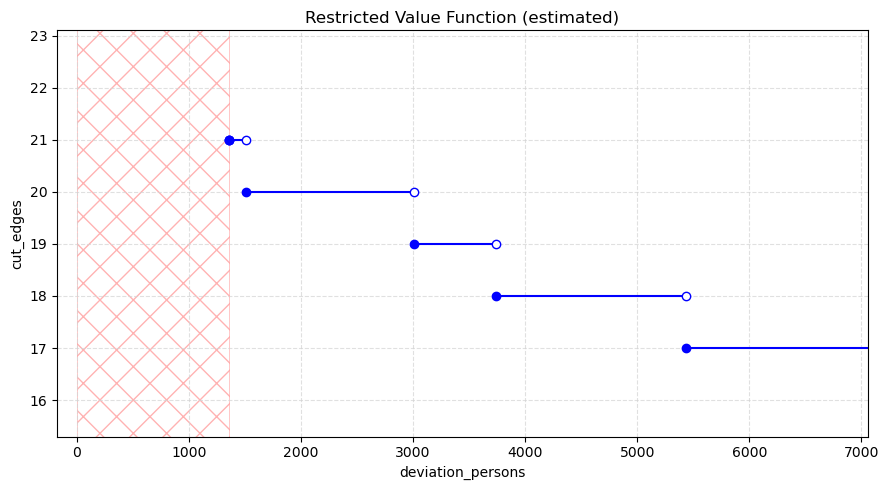

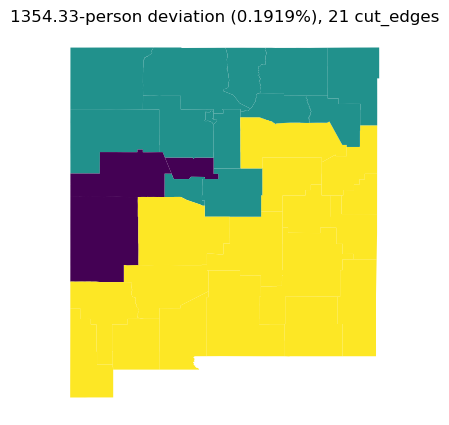

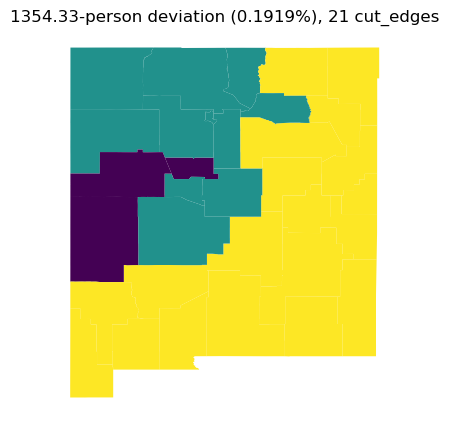

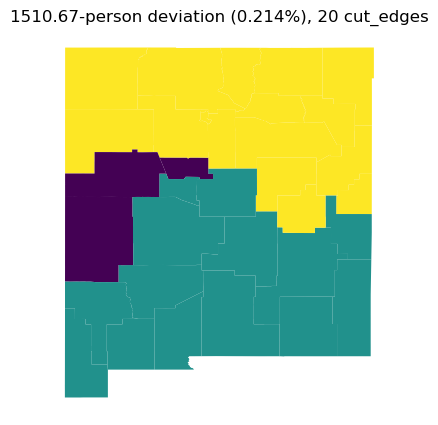

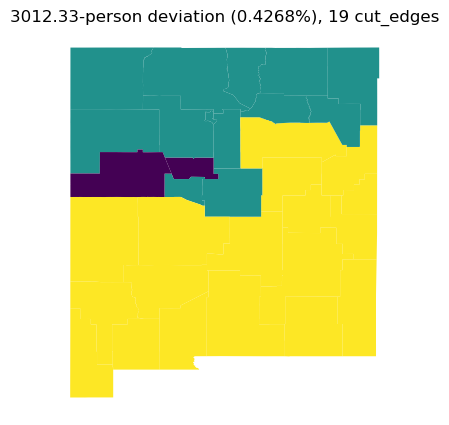

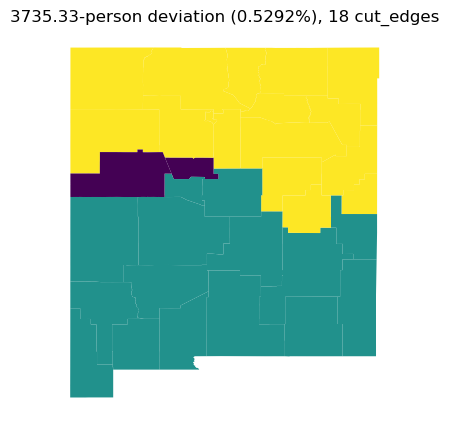

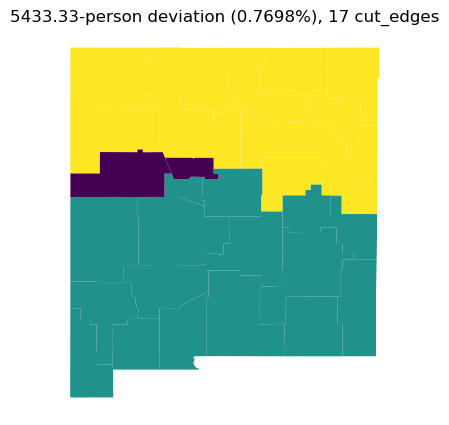

***************************************
obj_type = perimeter
***************************************
Pareto front objective values: [[1354.3333333333721, 55.50700622138527], [1510.6666666666279, 50.98912311192004], [3208.666666666628, 50.18372373556686], [3735.333333333372, 47.839336969480144], [5433.333333333372, 47.033937593126964]]


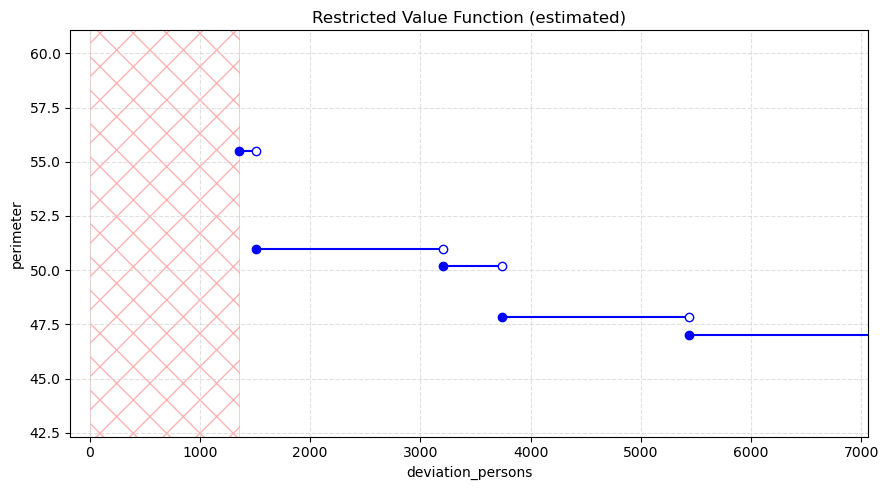

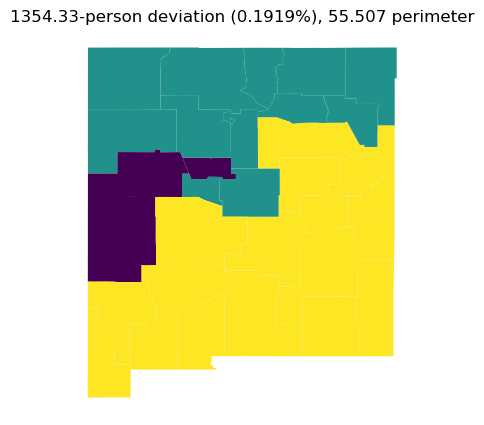

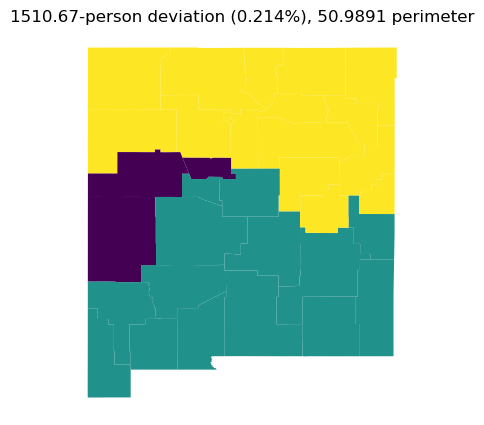

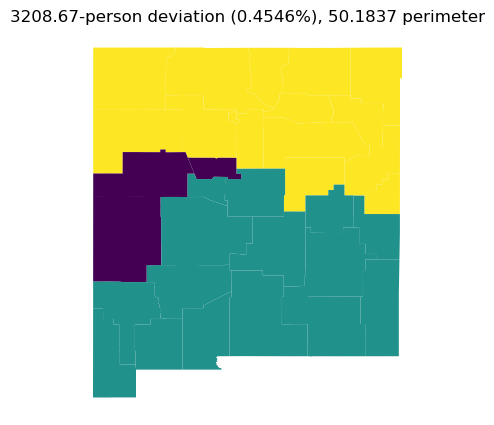

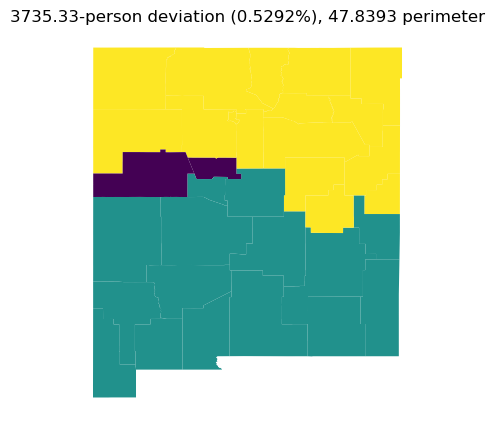

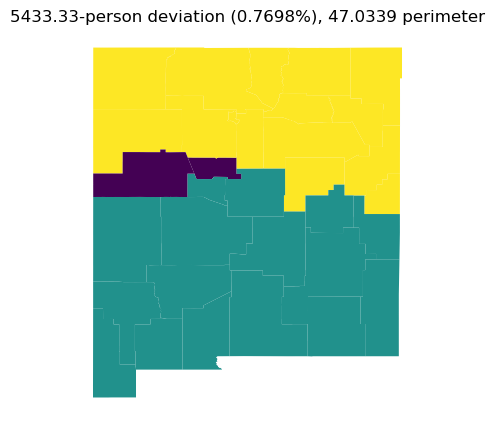

***************************************
obj_type = inverse_Polsby_Popper
***************************************
Pareto front objective values: [[1354.3333333333721, 2.8674776231990404], [1510.6666666666279, 2.4165485913761793], [3208.666666666628, 2.359282893226306], [5433.333333333372, 2.351294685741632]]


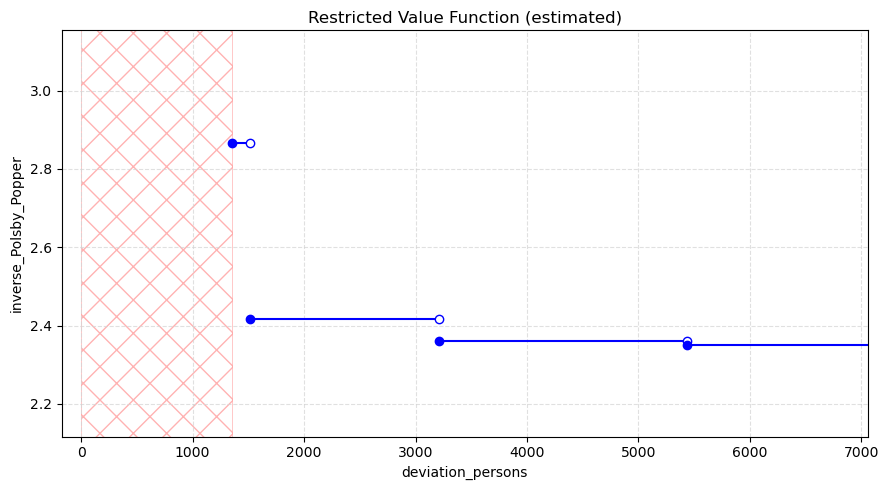

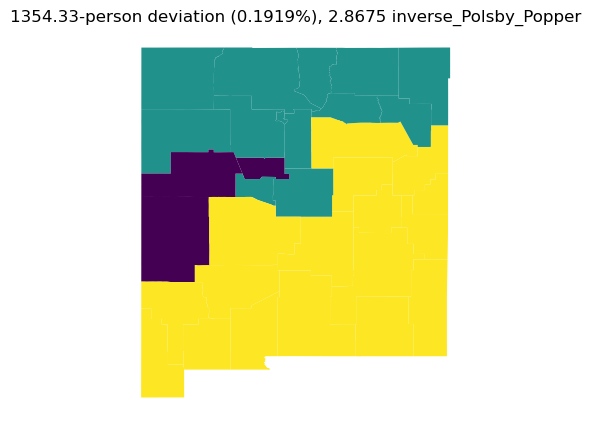

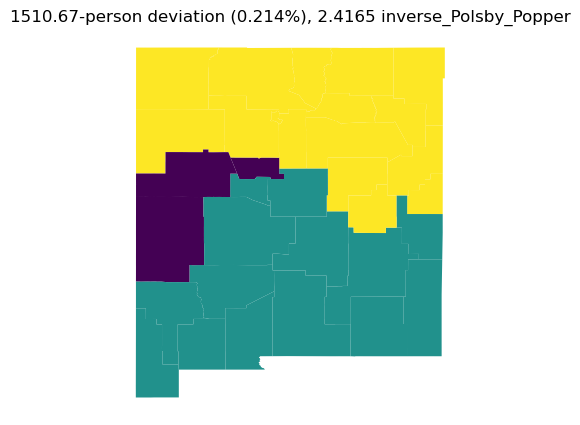

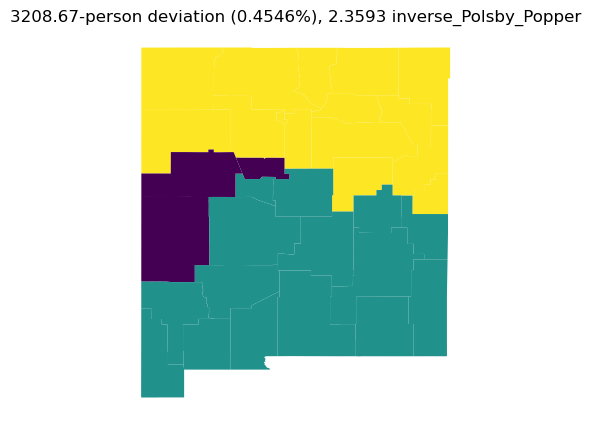

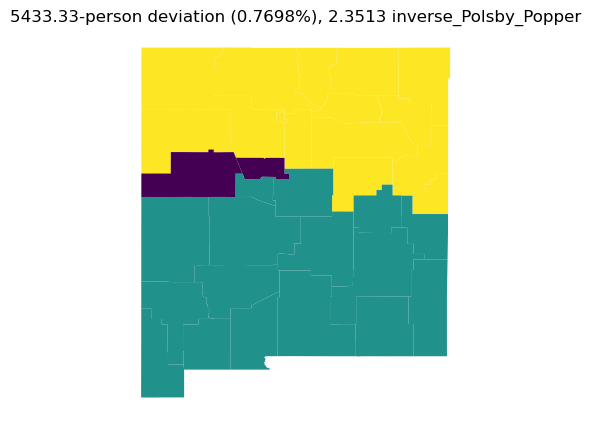

***************************************
obj_type = average_Polsby_Popper
***************************************
Pareto front objective values: [[1354.3333333333721, 0.3567720294858953], [1510.6666666666279, 0.415501415678718], [3208.666666666628, 0.42576644748134873], [5433.333333333372, 0.43342041766639655]]


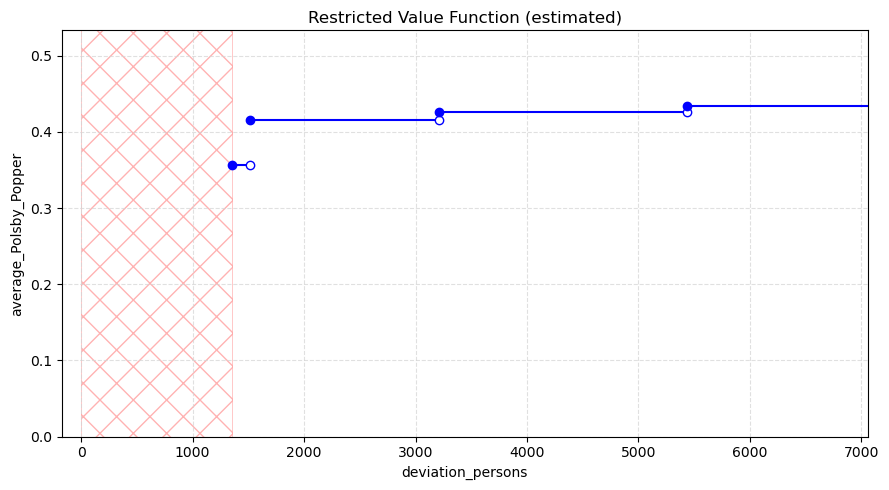

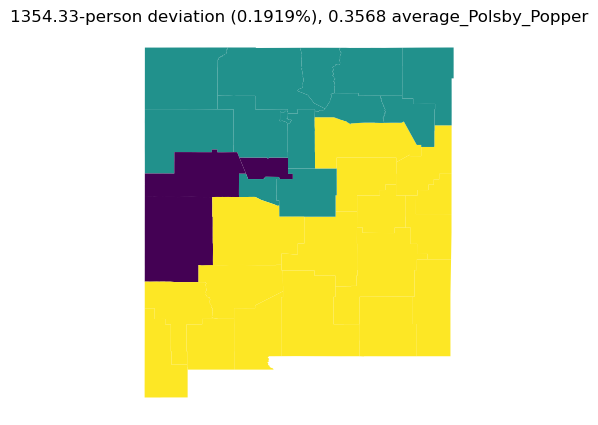

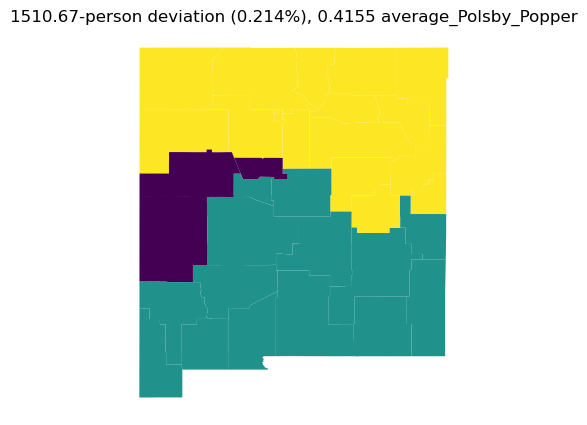

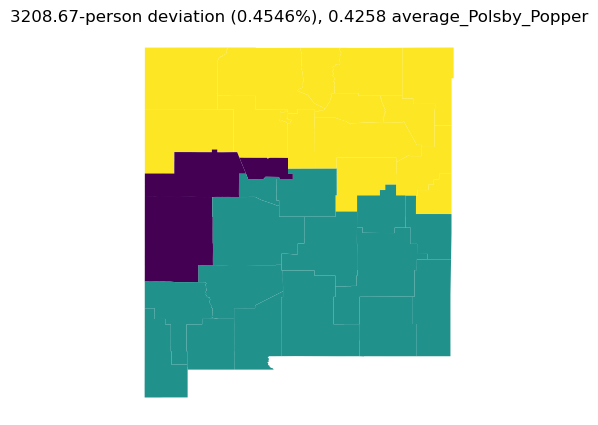

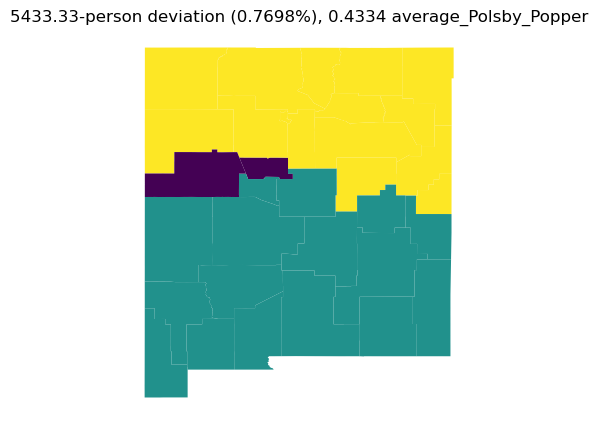

***************************************
obj_type = bottleneck_Polsby_Popper
***************************************
Pareto front objective values: [[1354.3333333333721, 0.2851744307921699], [1510.6666666666279, 0.3865841595621306]]


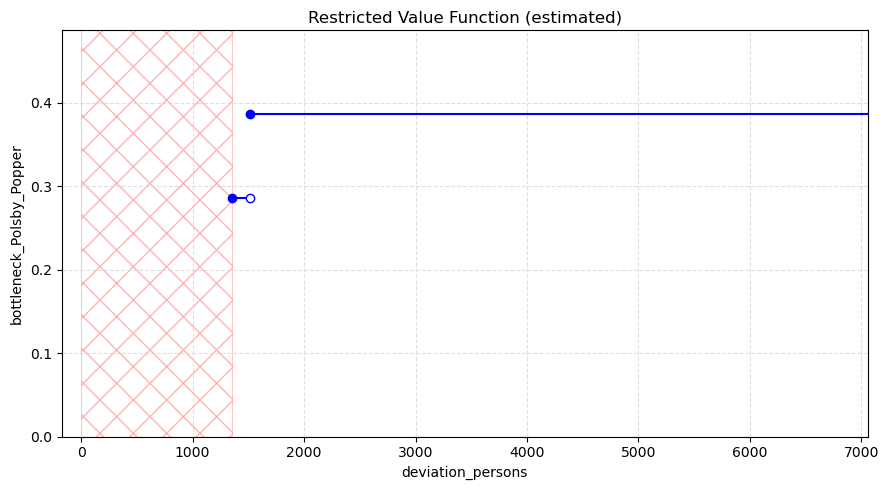

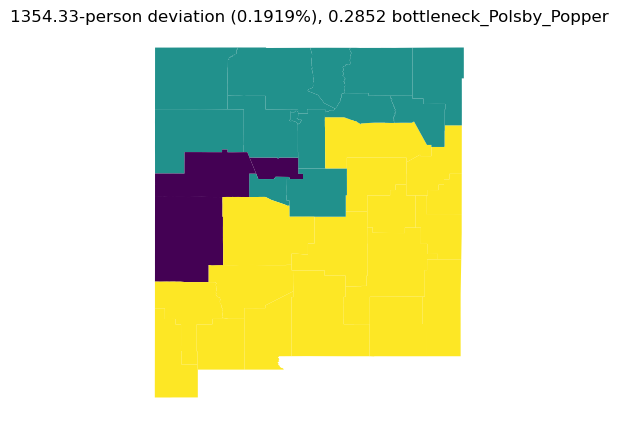

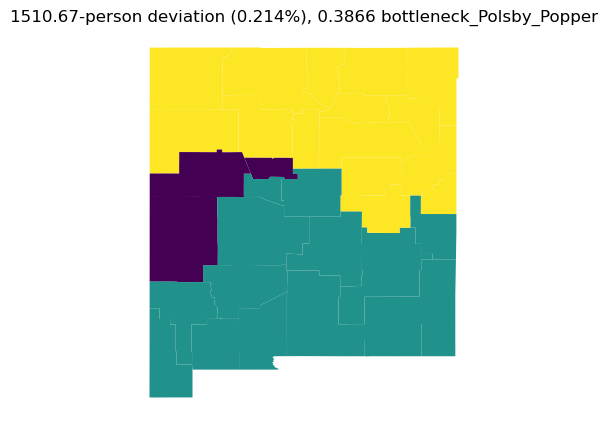

In [7]:
from pareto import plot_pareto_frontiers

obj_types = ['cut_edges', 'perimeter', 'inverse_Polsby_Popper', 'average_Polsby_Popper', 'bottleneck_Polsby_Popper']

pareto_plans = plot_pareto_frontiers(
                G,
                method='heuristic',
                plans=plans,                                   #if method ='epsilon_constraint_method' is None 
                obj_types=obj_types,                           #if method ='epsilon_constraint_method' is obj_type
                ideal_population=ideal_population,
                state=state,
                filepath=filepath,
                filename2=filename2,
                no_solution_region=no_solution_region,
                year=year,
                result=None,                                   #if method ='heuristic' is None 
             )

In [8]:
len(plans)

149

In [9]:
for obj_type in obj_types:
    print("***************************************")
    print("obj_type =", obj_type)
    print("***************************************")
    print("Pareto front plans:", pareto_plans[obj_type])

***************************************
obj_type = cut_edges
***************************************
Pareto front plans: [[[13, 18, 25], [2, 5, 7, 8, 11, 15, 19, 21, 23, 24, 27, 30, 31], [0, 1, 3, 4, 6, 9, 10, 12, 14, 16, 17, 20, 22, 26, 28, 29, 32]], [[13, 18, 25], [2, 5, 7, 8, 11, 15, 21, 24, 29, 30, 31], [0, 1, 3, 4, 6, 9, 10, 12, 14, 16, 17, 19, 20, 22, 23, 26, 27, 28, 32]], [[13, 18, 25], [1, 3, 5, 6, 9, 10, 14, 15, 17, 22, 26, 28, 29, 32], [0, 2, 4, 7, 8, 11, 12, 16, 19, 20, 21, 23, 24, 27, 30, 31]], [[13, 25], [2, 5, 7, 8, 11, 15, 19, 21, 23, 24, 27, 30, 31], [0, 1, 3, 4, 6, 9, 10, 12, 14, 16, 17, 18, 20, 22, 26, 28, 29, 32]], [[13, 25], [1, 3, 5, 6, 9, 10, 14, 15, 17, 18, 22, 26, 28, 29, 32], [0, 2, 4, 7, 8, 11, 12, 16, 19, 20, 21, 23, 24, 27, 30, 31]], [[13, 25], [1, 3, 5, 6, 9, 10, 14, 15, 16, 17, 18, 22, 26, 28, 29, 32], [0, 2, 4, 7, 8, 11, 12, 19, 20, 21, 23, 24, 27, 30, 31]]]
***************************************
obj_type = perimeter
*************************************